# Predict whether the cancer is benign or malignant using the Wisconsin Diagnostic Breast Cancer

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc


## Load the Data

### Reading the data from the CSV

In [95]:
data = pd.read_csv('data/wdbc-raw.csv')

Set up the colums for the data

In [96]:
columns = [
    'id',                        # 1) ID number
    'diagnosis',                 # 2) Diagnosis (M = malignant, B = benign)
    'radius_mean',               # 3) radius (mean of distances from center to points on the perimeter)
    'texture_mean',              # 4) texture (standard deviation of gray-scale values)
    'perimeter_mean',            # 5) perimeter
    'area_mean',                 # 6) area
    'smoothness_mean',           # 7) smoothness (local variation in radius lengths)
    'compactness_mean',          # 8) compactness (perimeter^2 / area - 1.0)
    'concavity_mean',            # 9) concavity (severity of concave portions of the contour)
    'concave_points_mean',       # 10) concave points (number of concave portions of the contour)
    'symmetry_mean',             # 11) symmetry
    'fractal_dimension_mean',    # 12) fractal dimension ("coastline approximation" - 1)
    'radius_se',                 # 13) radius (standard error)
    'texture_se',                # 14) texture (standard error)
    'perimeter_se',              # 15) perimeter (standard error)
    'area_se',                   # 16) area (standard error)
    'smoothness_se',             # 17) smoothness (standard error)
    'compactness_se',            # 18) compactness (standard error)
    'concavity_se',              # 19) concavity (standard error)
    'concave_points_se',         # 20) concave points (standard error)
    'symmetry_se',               # 21) symmetry (standard error)
    'fractal_dimension_se',      # 22) fractal dimension (standard error)
    'radius_worst',              # 23) radius (worst value)
    'texture_worst',             # 24) texture (worst value)
    'perimeter_worst',           # 25) perimeter (worst value)
    'area_worst',                # 26) area (worst value)
    'smoothness_worst',          # 27) smoothness (worst value)
    'compactness_worst',         # 28) compactness (worst value)
    'concavity_worst',           # 29) concavity (worst value)
    'concave_points_worst',      # 30) concave points (worst value)
    'symmetry_worst',            # 31) symmetry (worst value)
    'fractal_dimension_worst'    # 32) fractal dimension (worst value)
]

data.columns = columns

Review the first few rows of the data

In [97]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842517,M,200.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,84300903,M,19.69,NaN,130.00,1203.0,NaN,NaN,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,84348301,M,11.42,20.38,NaN,NaN,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
3,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
4,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


### Configure Features and Lables

In [98]:
X = data.drop(['id', 'diagnosis'], axis=1)

**Binary Encoding**

The `diagnosis` column is a categorical variable, so we will perform binary encoding as SVM needs numerical data for target input.

M = 1 for malignant and B = 0 for benign

In [99]:
Y = data['diagnosis'].map({'M': 1, 'B': 0})

pd.DataFrame(Y, columns=['diagnosis']).head()

,diagnosis
0,1
1,1
2,1
3,1
4,1


### Handling Missing Data

Check for missing values

In [100]:
null_values = X.isnull().sum()

print(f'There are {null_values.sum()} missing values in the dataset\n')
print(null_values[null_values > 0])

There are 37 missing values in the dataset

texture_mean              1
perimeter_mean            1
area_mean                 1
smoothness_mean           1
compactness_mean          1
concavity_mean            3
concave_points_mean       1
symmetry_mean             1
fractal_dimension_mean    2
radius_se                 1
texture_se                5
perimeter_se              4
smoothness_se             4
compactness_se            3
concave_points_se         3
fractal_dimension_se      2
perimeter_worst           3
dtype: int64


**Visualizing the data distributions to determine the best imputation strategy**

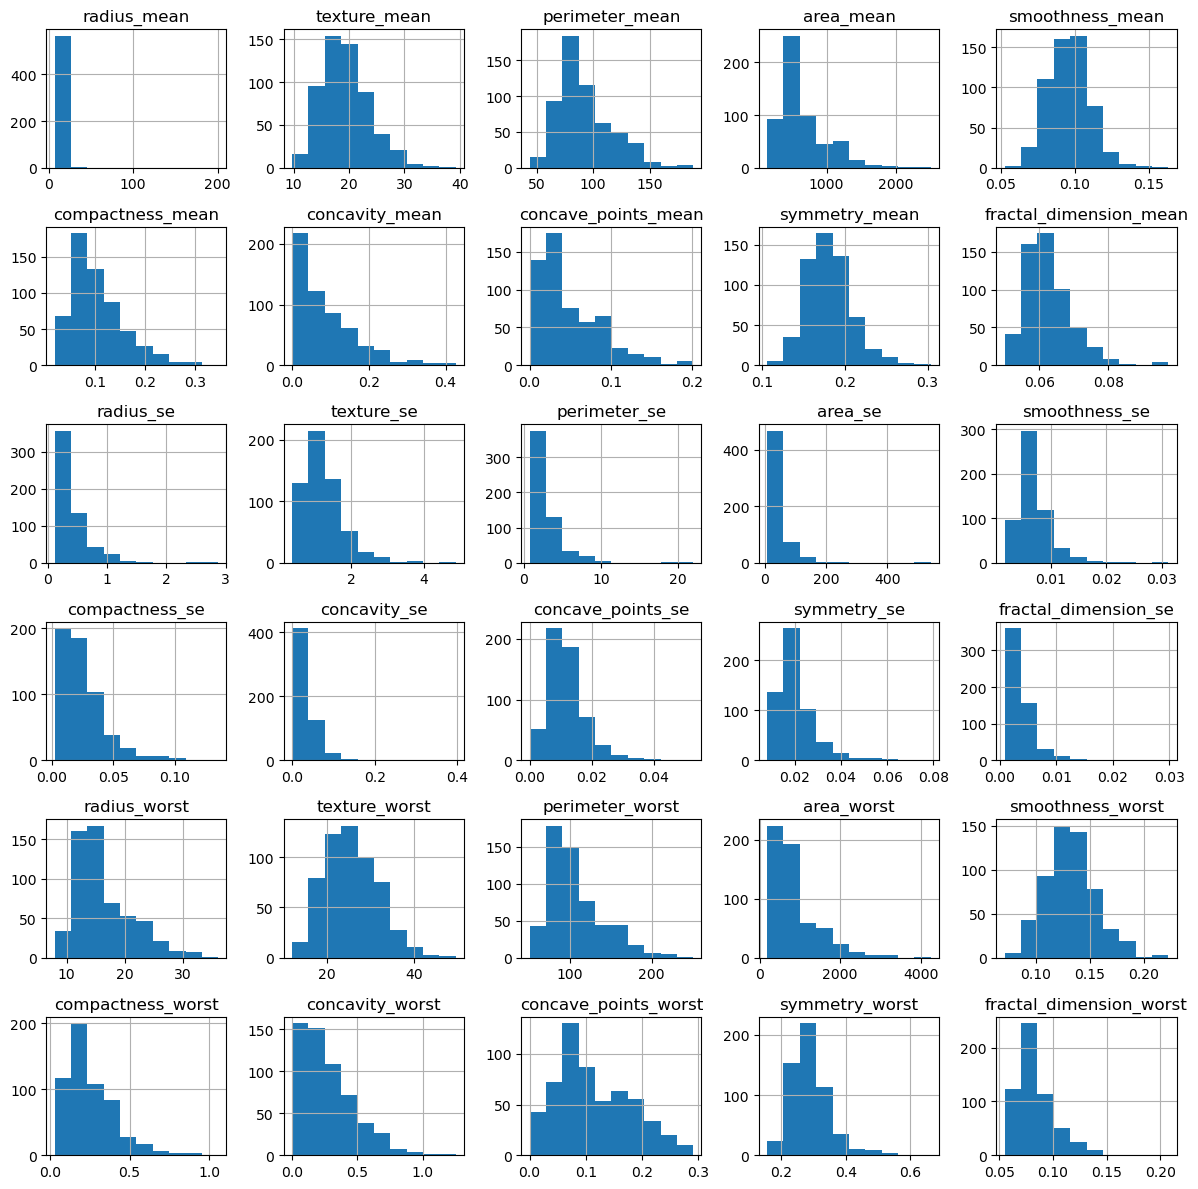

In [101]:
X.hist(figsize=(12, 12))
plt.tight_layout()
plt.show()

***Distribution Insights:***
- Most features show right-skewed distributions
- There are very few missing values (1-5 per feature)
- Features can be grouped into related sets:
    - Geometric (radius, area, perimeter)
    - Texture-based
    - Shape-based (concavity, symmetry)

***Median Imputation*** would be most appropriate here because:
- It is robust to the obvious right-skewed nature of most features
- Simple and transparent for medical data where interpretability is important
- With very few missing values (max 5 in any column), complex methods are unnecessary
- Median preserves the central tendency better than mean for these skewed distributions
- Won't introduce artificial relationships or complexity

***Why not other methods:***
- _Mean imputation_: Would be pulled by outliers in these skewed distributions
- _Mode imputation_: Unsuitable due to the continuous, non-categorical nature of most features
- _MICE/KNN_: Overly complex for such sparse missing data
- _Interpolation_: It assumes a smooth, continuous relationship between data points, which doesn't fit the non-sequential, skewed nature of this dataset
- _Row deletion_: Unnecessary given very few missing values

**Perform Median Imputation**

In [102]:
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

Preview the first 5 rows of the X_imputed dataframe to verify that the missing values have been imputed

In [103]:
print(f'There are now {X_imputed.isnull().sum().sum()} missing values in the dataset')

pd.concat([X_imputed, Y], axis=1).head()

There are now 0 missing values in the dataset


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,200.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
1,19.69,18.84,130.00,1203.0,0.09586,0.09242,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
2,11.42,20.38,86.24,551.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
3,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1
4,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,1


## Model Evaluation Utilities

Function to select the Best Kernel

In [104]:
def get_best_svm(X_train, Y_train, skip_grid_search=False):
    # Skip GridSearchCV if the flag is set to True to save test time
    if skip_grid_search:
        return SVC(kernel='linear', probability=True, random_state=42)

    svm = SVC()

    # Define the hyperparameter grid
    param_grid = {
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], # Kernel type
        'C': [0.1, 1, 10, 100],  # Regularization parameter
        'gamma': ['scale', 'auto']  # Kernel coefficient
    }

    # Perform a 5-fold cross-validation with GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=2)

    # Fit the model to the training data
    grid_search.fit(X_train, Y_train)

    # Print the best parameters and the best accuracy score
    print("Best parameters found: ", grid_search.best_params_)
    print("Best accuracy score: ", grid_search.best_score_)

    # Get the best model
    best_svm = grid_search.best_estimator_

    return best_svm

Function to plot the confusion matrix

In [133]:
def plot_confusion_matrix(conf_matrix):
    target_names=['Benign', 'Malignant']

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,)
    
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Diagnosis')
    plt.xlabel('Predicted Diagnosis')
    
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    plt.show()

Function to plot the ROC curve

In [134]:
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    
    plt.grid(True, linestyle='--', alpha=0.5) # Gridlines for better readability
    
    plt.show()

Function to evaluate the model performance

In [107]:
def evaluate_model(y_test, y_pred, y_pred_prob, svm_model, X_train, X_test, y_train):
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Benign', 'Malignant'])
    conf_matrix = confusion_matrix(y_test, y_pred)

    print("\nModel Performance Metrics:")
    print("-" * 50)

    print(f"Accuracy: {accuracy * 100:.2f}%")

    print("\nClassification Report:")
    print(report)

    print("\nConfusion Matrix:")
    plot_confusion_matrix(conf_matrix)

    print("\nROC Curve:")
    plot_roc_curve(y_test, y_pred_prob)

    train_accuracy = svm_model.score(X_train, y_train)
    test_accuracy = svm_model.score(X_test, y_test)

    print("\nModel Accuracy Scores:")
    print("-" * 50)
    print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

# Test Model on the Initial Data

Splitting the dataset into training and test sets (80% train, 20% test)

In [108]:
X_train, X_test, Y_train, Y_test = train_test_split(X_imputed, Y, test_size=0.2, random_state=42)

Get the best SVM Kernel

In [109]:
svm_model = get_best_svm(X_train, Y_train, False)

Training the SVM classifier using best kernel

In [110]:
svm_model.fit(X_train, Y_train)

SVC(kernel='linear', probability=True, random_state=42)

Making predictions on the test set

In [111]:
Y_pred = svm_model.predict(X_test)
y_pred_prob = svm_model.predict_proba(X_test)[:, 1]

Evaluating model performance


Model Performance Metrics:
--------------------------------------------------
Accuracy: 91.23%

Classification Report:
              precision    recall  f1-score   support

      Benign       0.89      0.97      0.93        68
   Malignant       0.95      0.83      0.88        46

    accuracy                           0.91       114
   macro avg       0.92      0.90      0.91       114
weighted avg       0.92      0.91      0.91       114


Confusion Matrix:


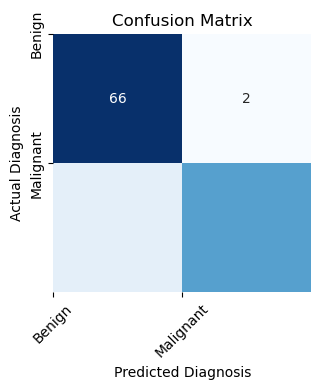


ROC Curve:


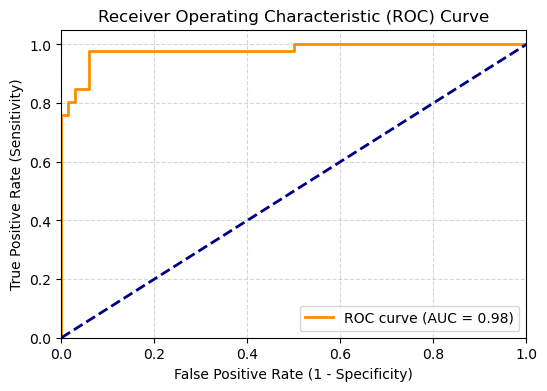


Model Accuracy Scores:
--------------------------------------------------
Training Accuracy: 97.36%
Testing Accuracy: 91.23%


In [135]:
evaluate_model(Y_test, Y_pred, y_pred_prob, svm_model, X_train, X_test, Y_train)

***Key Insights:***
- The model shows reasonably good performance with both accuracies above 87%
- The moderate gap (5%) between training and testing accuracy suggests mild overfitting, but nothing severe
- The model generalizes fairly well to unseen data, as the test accuracy remains strong

In [113]:
mm = 0.1

## Data visualizaton and Feature selection

#### Correlation matrix

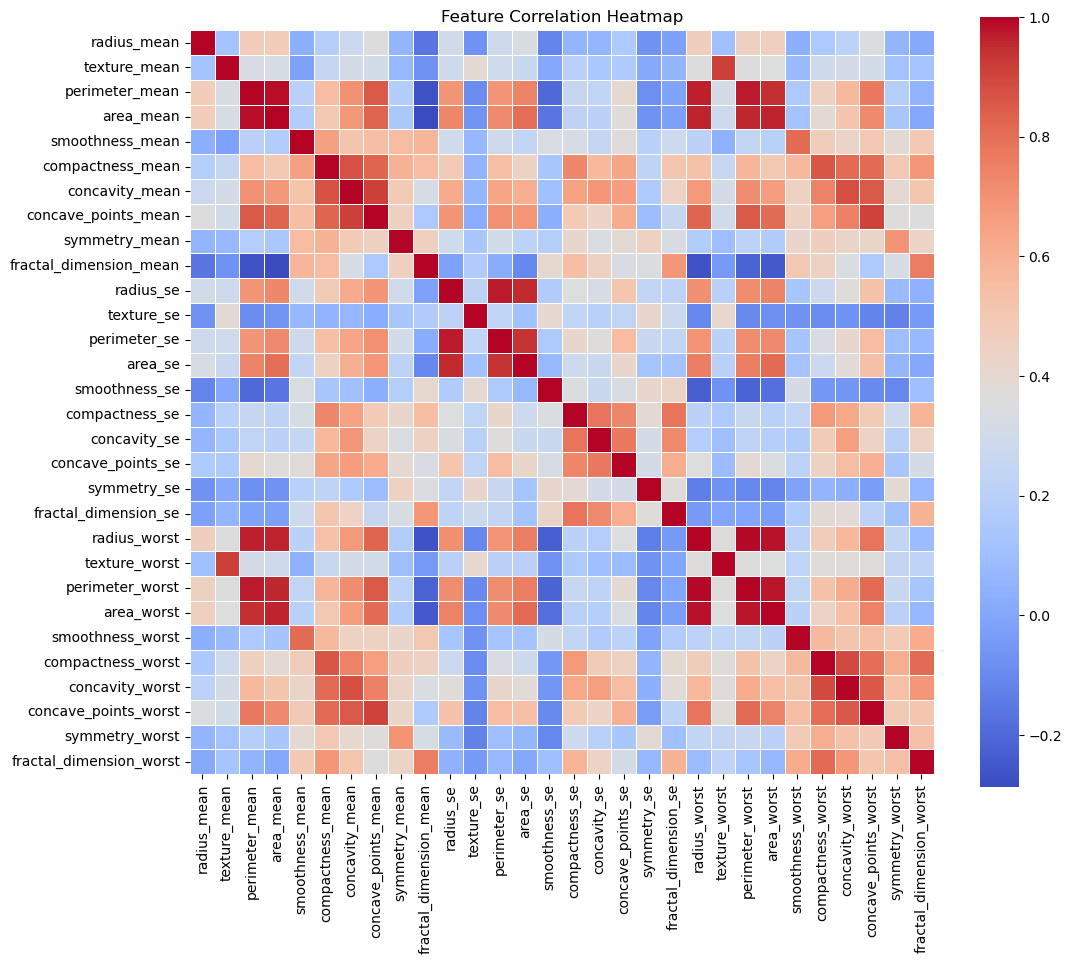

In [114]:
correlation_matrix = X_imputed.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

**Observations**:

1. ***Strong Feature Groupings:***
- There are strong correlations between `radius`, `perimeter`, and `area` measurements across all three categories (mean, SE, and worst), shown by the dark red squares. This makes sense geometrically as these are related measurements.
- `texture` features show moderate correlations with each other across the different measurement types (mean, SE, worst).

2. ***Concavity-Related Correlations:***
- `concavity`, `concave points`, and `compactness` show moderate to strong positive correlations with each other (shown in red/pink squares)
- This suggests these features describing the irregularity of cell shapes tend to vary together.

3. ***Measurement Types:***
- The "worst" measurements generally show stronger correlations with other features compared to their "mean" or "SE" counterparts
- Standard error (SE) measurements show weaker correlations overall (more light colors), suggesting they might capture different aspects of variability

4. ***Independent Features:***
- `fractal dimension` shows relatively weak correlations with most other features (mostly light blue/white colors)
- `Symmetry` also appears to be relatively independent of other features
- These more independent features might provide unique information for diagnosis

5. ***Potential Feature Selection Implications:***
- The more independent features like `fractal dimension` and `symmetry` might be important to retain as they capture unique aspects of the data
- We can eliminate these columns to reduce redundancy:
    - `perimeter_mean`: strongly correlated with `radius_mean` and `area_mean`
    - `perimeter_se`: strongly correlated with `radius_se` and `area_se`
    - `concavity_mean`: moderately correlated with `concave_points_mean` and `symmetry_mean`
    - `concavity_se`: moderately correlated with `concave_points_se` and `symmetry_se`



In [115]:
print("Original shape of X:", X_imputed.shape)

# Dropping the specified columns to reduce redundancy
columns_to_drop = [
    'perimeter_mean',     # Strongly correlated with radius_mean and area_mean
    'perimeter_se',       # Strongly correlated with radius_se and area_se
    'concavity_mean',     # Moderately correlated with concave_points_mean and symmetry_mean
    'concavity_se'        # Moderately correlated with concave_points_se and symmetry_se
]

X_reduced = X_imputed.drop(columns=columns_to_drop)

# Displaying the shape of the reduced X for reference
print("Reduced shape of X:", X_reduced.shape)

Original shape of X: (568, 30)
Reduced shape of X: (568, 26)


#### Pair Plot (Scatterplot Matrix)

/Users/mzitoh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mzitoh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mzitoh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mzitoh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119:

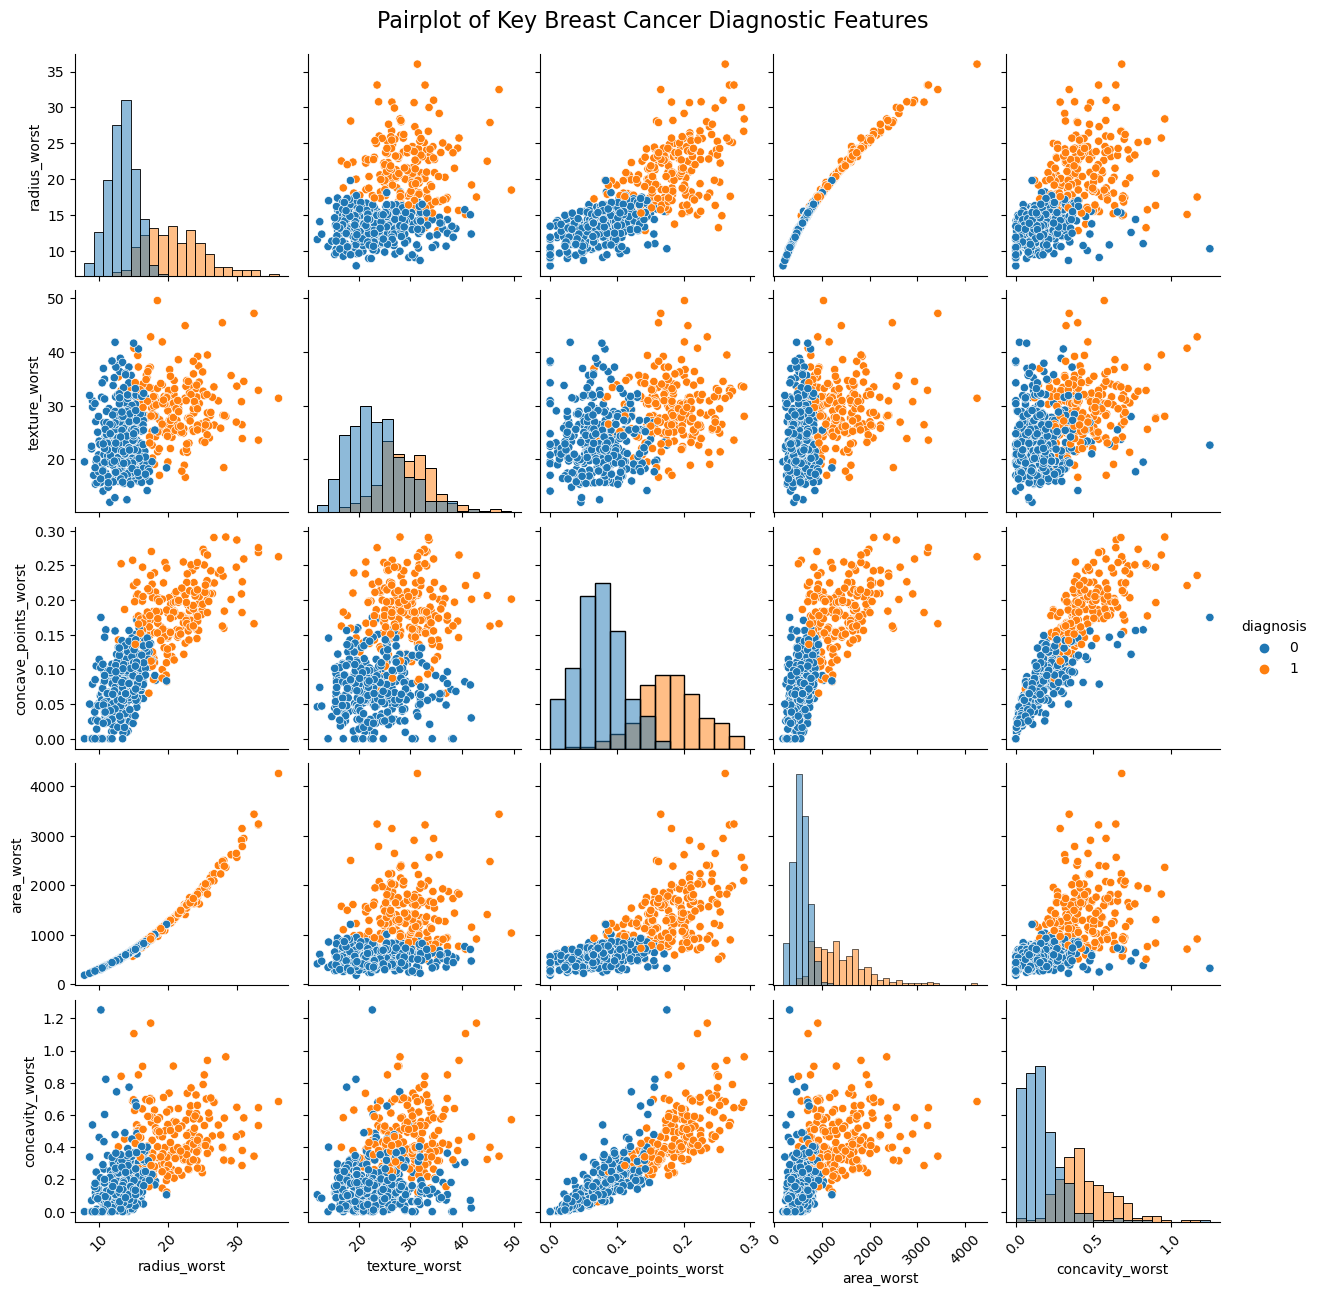

In [116]:
# Define the selected features
selected_features = ['radius_worst', 'texture_worst', 'concave_points_worst', 
                    'area_worst', 'concavity_worst']

# Create DataFrame with selected features and diagnosis
select_data = pd.DataFrame(X_reduced, columns=selected_features)
select_data['diagnosis'] = Y

# Set style and create the pairplot
# sns.set_theme(style='seaborn', palette='Set2')
g = sns.pairplot(select_data, hue='diagnosis', diag_kind='hist', height=2.5)

# Customize the plot
g.figure.suptitle('Pairplot of Key Breast Cancer Diagnostic Features', y=1.02, size=16)

# Rotate x-axis labels for readability
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

plt.show()


## Data transformations

**Log Transformation** - This will reduce skewness in features that have extreme values or long tails, making the data more normally distributed.

Features like `area_mean`, `perimeter_mean`, and `concavity_mean` are often skewed due to the nature of the data (e.g., size and shape of tumors).

The SVM model will perform better when features are normally distributed or closer to a Gaussian distribution. This transformation helps achieve that.

By reducing skewness, the transformed features become less sensitive to outliers, improving the classifier's ability to generalize.

In [117]:
X_transformed = X.apply(lambda x: np.log(x + 1) if x.skew() > 1 else x)

**Standardization** - This will ensure that all features have a similar scale and contribute equally to the SVM model, which is highly sensitive to feature scaling.

In [118]:
X_standardized = StandardScaler().fit_transform(X_transformed)